In [1]:
import random
import warnings

import pandas as pd 
import numpy as np
from typing import Dict
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from compreface import CompreFace
from compreface.service import RecognitionService
from compreface.collections import FaceCollection
from compreface.collections.face_collections import Subjects

DOMAIN: str = 'http://localhost'
PORT: str = '8000'
API_KEY_RECOGNITON: str = '00000000-0000-0000-0000-000000000002'

np.random.seed(6789)

# Benchmark function

In [2]:

class Benchmark(): 
    def __init__(self) -> None:
        self.compre_face: CompreFace = CompreFace(DOMAIN, PORT)
        self.recognition: RecognitionService = self.compre_face.init_face_recognition(API_KEY_RECOGNITON)
        self.face_collection: FaceCollection = self.recognition.get_face_collection()
        self.subjects: Subjects = self.recognition.get_subjects()

    def register_faces(self, faces_map, verbose = 0): 
        """
        Train faces using the compreFace API.

        Args:
            faces_map (dict): A dictionary containing the name of the individual as the key and a list of photos as the value.
            verbose (int): An optional argument to set the level of verbosity. Default is 0.

        The function uses the compreFace API to train faces in the provided photos. The input is a dictionary where the keys
        are the names of the individuals and the values are lists of photo file names. The function first cleans the
        previously trained faces by deleting all the subjects. Then it loads each photo from the file path, adds it to the
        face collection using the compreFace API, and associates it with the corresponding individual. If the `verbose`
        argument is set to 0, the function prints a message indicating that the trained faces are being cleaned.

        Note: This function assumes that the `face_collection` object is already initialized and available as an instance
        variable in the `self` object.
        """
        if verbose == 0: 
            print("Cleaning trained faces")

        subject_list = self.subjects.list()["subjects"]
        for ind in subject_list: 
            self.subjects.delete(ind)

        for name, images in faces_map.items():
            for file_path in images: 
                file_path = f'../img_data/img_align_celeba/{file_path}'
                self.face_collection.add(image_path=file_path, subject=str(name))

    def test_faces(self, test_map):
        """
        Tests the accuracy of the face recognition model on a set of test images.
        
        Args:
            test_map : dict
                A dictionary containing a mapping between labels and lists of image file names to be used for testing.
            
        Returns:
            df : pandas.DataFrame
                A DataFrame containing the results of the test, including the label, predicted subject, similarity score, and 
                file name for each tested image.
        """
        results = []
        for ind, images in test_map.items(): 
            for file_path in images:
                test_image = open(f'../img_data/img_align_celeba/{file_path}', "rb").read()
                result = self.recognition.recognize(image_path=test_image)
                result = result.get("result", [])
                if result != []:
                    #In case there are multiple results, the function only keeps the best one
                    best_result = ["", "", 0, ""]
                    for face in result: 
                        for predictions in face['subjects']: 
                            prediction = predictions['subject']
                            similarity = predictions['similarity']
                            if best_result[2] < similarity:  
                                best_result = [str(ind), str(prediction), similarity, file_path]
                        results.append(best_result)
                else:
                    results.append([str(ind), None, None, file_path])
        
        df = pd.DataFrame(results, columns=['ind', 'prediction', 'similarity', 'photo'])
        return df

    def extract_random_element(self, d, n_train):
        """
        Extract a random subset of elements from each value list of the input dictionary.

        Args:
            self (object): An instance of the object.
            d (dict): A dictionary containing the input key-value pairs.
            n_train (int): The number of elements to extract from each value list.

        Returns:
            train_dict (dict): A dictionary containing the same keys as the input dictionary, but with a randomly selected
            subset of values for each key.
            test_dict (dict): A dictionary containing the same keys as the input dictionary, but with the remaining values
            that were not selected for the training set.

        The function takes an input dictionary `d`, where the keys represent groups of elements, and the values are lists of
        elements belonging to each group. It randomly selects a fixed number (`n_train`) of elements from each value list
        and adds them to the `train_dict` dictionary. The remaining elements are added to the `test_dict` dictionary. The
        function returns both dictionaries.
        """
        train_dict = {}
        test_dict = {}
        for k, v in d.items():
            train_dict[k] = []
            for i in range(n_train): 
                if len(v) > 0:
                    rand_elem = random.choice(v)
                    train_dict[k].append(rand_elem)
                    v.remove(rand_elem)
            test_dict[k] = v
        return train_dict, test_dict

    def family_benchmark(self, metadata_subset, n_interations, n_individuals, n_photos_train, n_photos_test_family, n_photos_test_group, verbose = 0): 
        """
        Evaluates the performance of the face recognition model on a family dataset by training on a subset of 
        individuals and testing on two different sets of images: 
            - Testing on images of the same individuals as the training set
            - Testing on images of new individuals not present in the training set
        The performance is evaluated over n_interations, where each iteration involves:
            - Sampling a subset of individuals from the metadata_subset dataframe
            - Splitting the subset into training and testing sets
            - Training the face recognition model using the training set
            - Testing the model on the testing sets (same individuals and new individuals)
        The function returns two dataframes with the results of the two types of testing sets: performace and 
        performace_new_individuals.

        Args:
        - metadata_subset: Pandas dataframe with columns 'ind' (individual) and 'photo' (image filename) containing 
        metadata of a subset of the full family dataset.
        - n_interations: Integer with the number of iterations to run the evaluation.
        - n_individuals: Integer with the number of individuals to sample from the metadata_subset dataframe in each 
        iteration.
        - n_photos_train: Integer with the number of photos per individual to use for training.
        - n_photos_test_family: Integer with the number of photos per individual to use for testing (same individuals).
        - n_photos_test_group: Integer with the number of individuals to sample from the remaining individuals in the
        metadata_subset dataframe to use for testing (new individuals).
        - verbose: Integer indicating the verbosity of the function (0: no print statements; 1: print statements every 
        5 iterations).

        Returns:
        Tuple with two pandas dataframes:
        - performace: Dataframe with columns 'ind' (individual), 'prediction' (predicted individual), 'similarity' 
        (similarity score between image and prediction), and 'photo' (image filename) for the testing on the same 
        individuals.
        - performace_new_individuals: Dataframe with columns 'ind' (individual), 'prediction' (predicted individual),
        'similarity' (similarity score between image and prediction), and 'photo' (image filename) for the testing on 
        new individuals.
        """

        n_total = n_photos_train + n_photos_test_family
        
        performace = []
        performace_new_individuals = []

        for i in range(n_interations):
            if i % 5 == 0 and verbose == 0: 
                print(f"Running iteration nº {i}")

            # Subset individuals
            unique_inds = metadata_subset['ind'].unique()
            sampled_inds = np.random.choice(unique_inds, size=n_individuals, replace=False)
            sampled_data = metadata_subset[metadata_subset['ind'].isin(sampled_inds)]

            # Group the dataframe by individual and extract the first image
            grouped = sampled_data.groupby('ind')

            # extract the first n images from each individual
            selected_img = {}
            for name, group in grouped:
                selected_img[name] = group.iloc[0:n_total]['photo'].tolist()

            train_dict, test_dict = self.extract_random_element(selected_img, n_train= n_photos_train)
            
            # Train faces 
            self.register_faces(train_dict, verbose=1)
            
            #Test new photos (same individuals)
            performace_test = self.test_faces(test_dict) 
            performace.append(performace_test)

            #Test on new photos (new individuals)
            # Subset individuals
            metadata_subset_new = metadata_subset[~metadata_subset['ind'].isin(sampled_inds)]
            unique_inds = metadata_subset_new['ind'].unique()
            
            sampled_inds = np.random.choice(unique_inds, size=n_photos_test_group, replace=False)
            sampled_data = metadata_subset_new[metadata_subset_new['ind'].isin(sampled_inds)]

            # Group the dataframe by individual and extract the first image
            grouped = sampled_data.groupby('ind')

            # extract the first image from each individual
            selected_img = {}
            for name, group in grouped:
                selected_img[name] = group.iloc[0:1]['photo'].tolist()
                
            performace_table = self.test_faces(selected_img) 
            performace_new_individuals.append(performace_table)
    

        self.performace = pd.concat(performace, axis=0)
        self.performace_new_individuals = pd.concat(performace_new_individuals, axis = 0)

# Utility Functions

In [3]:
def performance_metrics(df_all, actual_col, prediction_col, min_confidence = 0):
    """Calculate performance metrics for classification models.

    This function takes a DataFrame `df_all` that contains actual and predicted labels
    for a classification task, and returns a dictionary of performance metrics,
    including Accuracy, Precision, Recall, F1 Score, and the percentage of ignored predictions.

    Parameters
    ----------
    df_all : pandas.DataFrame
        A DataFrame containing actual and predicted labels for a classification task.
    actual_col : str
        The name of the column in `df_all` that contains the actual labels.
    prediction_col : str
        The name of the column in `df_all` that contains the predicted labels.
    min_confidence : float, optional
        The minimum confidence threshold for the predicted labels. 
        Predictions with confidence below this threshold will be ignored.
        Default is 0.

    Returns
    -------
    dict
        A dictionary containing the following performance metrics:
            - 'Accuracy': the accuracy score of the predicted labels.
            - 'Precision': the precision score of the predicted labels.
            - 'Recall': the recall score of the predicted labels.
            - 'F1 Score': the F1 score of the predicted labels.
            - 'prediction_ignored': the percentage of ignored predictions based on the minimum confidence threshold.
    """
    
    df = df_all[df_all['similarity'] > min_confidence]
    predictions_ignored = 100* (df_all.shape[0] - df.shape[0]) / df_all.shape[0]
    y_true = df[actual_col].tolist()
    y_pred = df[prediction_col].tolist()
    
    warnings.filterwarnings('ignore', category=UserWarning) # Used due to pesky warning with the precision score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    warnings.filterwarnings('default')
    
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, "prediction_ignored" : predictions_ignored}
    
    return metrics

def output_metrics_table(performace: pd.DataFrame, min_conf: float, max_conf: float, step: float) -> pd.DataFrame:
    """
    Iterates over different confidence thresholds with a specified step size and outputs the metrics for each
    threshold in a table format.

    Args:
        performace (pd.Dataframe): A dataframe containing the performance metrics.
        min_conf (float): The minimum confidence threshold to start the iteration from.
        max_conf (float): The maximum confidence threshold to end the iteration at.
        step (float): The step size for the confidence threshold.
    Returns:
        pd.DataFrame: A pandas DataFrame containing the confidence threshold and corresponding precision,
        recall, f1, and accuracy metrics for each threshold, as well as the number of ignored predictions
    """
    metrics = ["Precision", "Recall", "F1 Score", "Accuracy", "prediction_ignored"]
    results = pd.DataFrame(columns=["Confidence Threshold"] + metrics)

    
    conf_range = [round(x, 2) for x in list(np.arange(min_conf, max_conf+step, step))]

    for conf in conf_range:
        perf_metrics = performance_metrics(performace, "ind", "prediction", min_confidence=conf)
        metric_values = [perf_metrics[metric] for metric in metrics]
        results = pd.concat([results, pd.DataFrame({"Confidence Threshold": conf, **dict(zip(metrics, metric_values))}, index=[0])])
    return results

# Run Benchmark

In [4]:
metadata = pd.read_csv("../metadata/identity_CelebA.txt", delimiter = " ", header=0, names = ["photo", "ind"])
ind_counts = metadata['ind'].value_counts()
selected_inds = ind_counts[ind_counts >= 20].index
metadata_subset = metadata[metadata['ind'].isin(selected_inds)]


## First Scenario:  Family of 4 Train using 1 photo

In [5]:
benchmark_train_4 = Benchmark()
benchmark_train_4.family_benchmark(metadata_subset, n_interations = 25, 
                                   n_individuals = 4, n_photos_train = 1, n_photos_test_family = 4, 
                                   n_photos_test_group = 100)


Running iteration nº 0
Running iteration nº 5
Running iteration nº 10
Running iteration nº 15
Running iteration nº 20


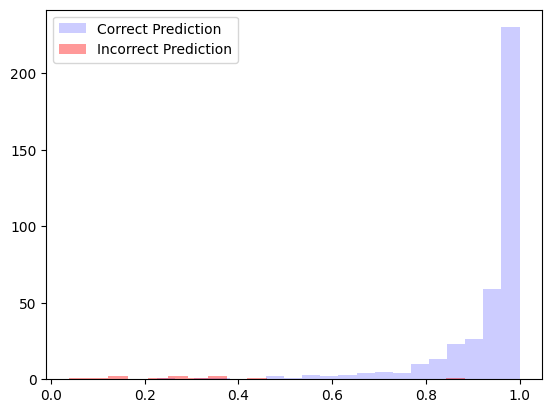

In [6]:
# Plot a value histogram for the known individual test
performace = benchmark_train_4.performace.copy()
performace.to_csv("tables/01.1_Family_benchmark_performance.csv")

performace["correct_prediction"] = np.where(performace["ind"] == performace["prediction"], True, False)

mask = performace['correct_prediction'] == True
correct_df = performace[mask]
incorrect_df = performace[~mask]

# Plot the histograms

plt.hist(correct_df['similarity'], alpha=0.2, color='blue', bins = 20, label='Correct Prediction')
plt.hist(incorrect_df['similarity'], alpha=0.4, color='red', bins = 20, label='Incorrect Prediction')
plt.legend()
plt.savefig("report_figures/01.1_Family_benchmark_histogram_knownPhotos.png")
plt.show()

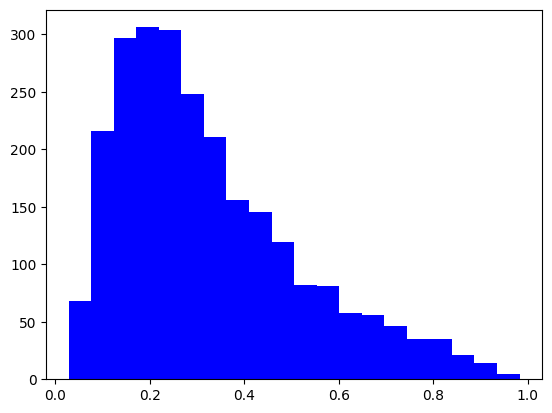

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
# Plot a value histogram for the unknown individual test
# Plot the histograms
performace_new_individuals = benchmark_train_4.performace_new_individuals.copy()
performace_new_individuals.to_csv("tables/01.1_Family_benchmark_performance_new_inviduals.csv")


plt.hist(performace_new_individuals['similarity'], color='blue', bins = 20)
plt.savefig("report_figures/01.1_Family_benchmark_histogram_newPhotos.png")
plt.show()

metrics_table_new_individuals = output_metrics_table(performace_new_individuals, min_conf = min(performace_new_individuals["similarity"]), max_conf = 1, step = 0.05)
metrics_table_new_individuals.to_csv("tables/01.1_Family_benchmark_performance_metrics_new_individuals.csv")

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


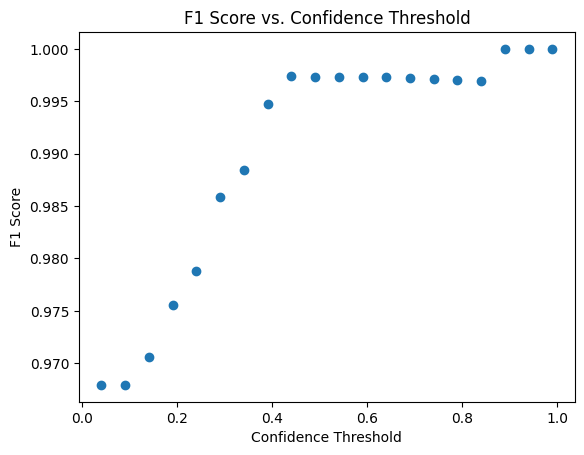

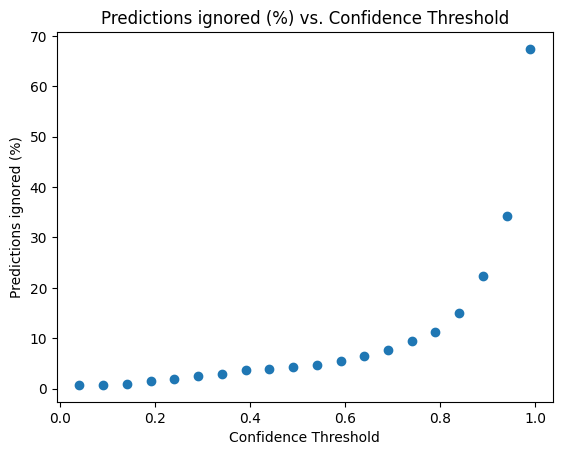

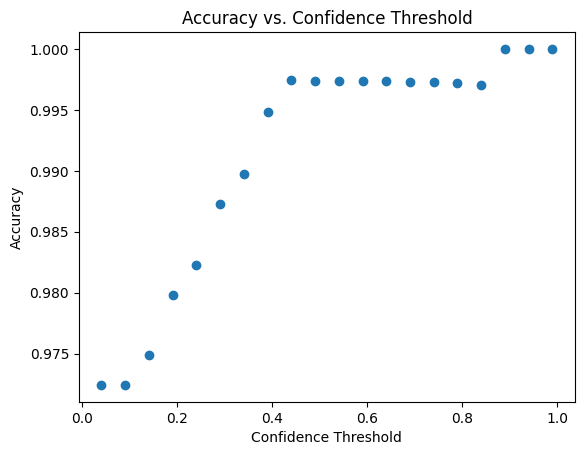

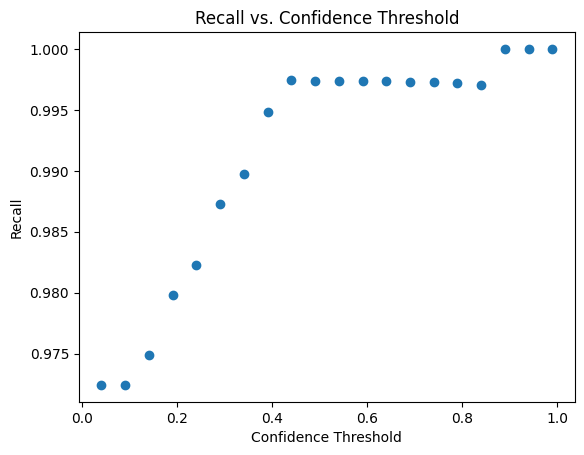

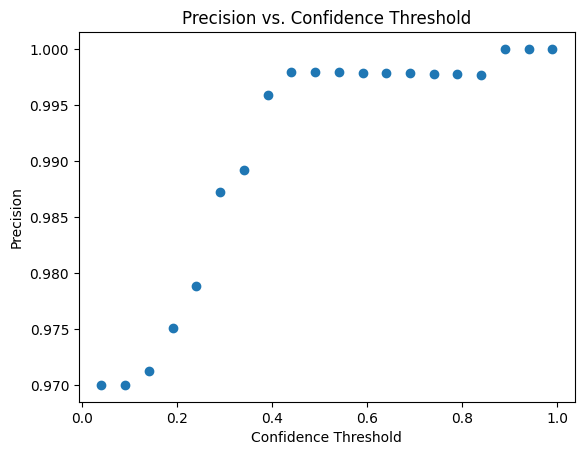

In [8]:
metrics_table = output_metrics_table(performace, min_conf = min(performace["similarity"]), max_conf = 1, step = 0.05)
metrics_table.to_csv("01.1_Family_benchmark_performance_metrics.csv")

# Filter out NaN values
metrics_table = metrics_table[~metrics_table["Accuracy"].isna()]

#Plot: Recall	F1 Score	Accuracy	prediction_ignored

# Plot scatter plot of F1-score vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["F1 Score"])
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Confidence Threshold")
plt.savefig("report_figures/01.1_Family_benchmark_scatterplot_F1vsConfidance.png")
plt.show()

plt.scatter(metrics_table["Confidence Threshold"], metrics_table["prediction_ignored"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Predictions ignored (%)")
plt.title("Predictions ignored (%) vs. Confidence Threshold")
plt.savefig("report_figures/01.1_Family_benchmark_scatterplot_PredictionsignoredVSConfidance.png")
plt.show()


# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Accuracy"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Confidence Threshold")
plt.savefig("report_figures/01.1_Family_benchmark_scatterplot_AccuracyvsConfidance.png")
plt.show()

# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Recall"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs. Confidence Threshold")
plt.savefig("report_figures/01.1_Family_benchmark_scatterplot_RecallvsConfidance.png")
plt.show()


# Plot scatter plot of Precision vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Precision"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs. Confidence Threshold")
plt.savefig("report_figures/01.1_Family_benchmark_scatterplot_PrecisionvsConfidance.png")
plt.show()

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


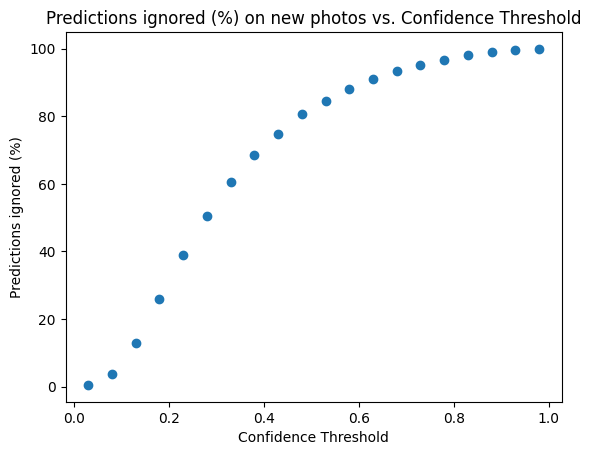

In [9]:
metrics_table_new_individuals = output_metrics_table(performace_new_individuals, min_conf = min(performace_new_individuals["similarity"]), max_conf = 1, step = 0.05)

# Filter out NaN values
metrics_table_new_individuals = metrics_table_new_individuals[~metrics_table_new_individuals["Accuracy"].isna()]

plt.scatter(metrics_table_new_individuals["Confidence Threshold"], metrics_table_new_individuals["prediction_ignored"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Predictions ignored (%)")
plt.title("Predictions ignored (%) on new photos vs. Confidence Threshold")
plt.savefig("report_figures/01.1_Family_benchmark_scatterplot_PredictionsignoredNewIndividualsVSConfidance.png")
plt.show()

## Second Scenario:  Family of 4 Train using 5 photo

In [ ]:
benchmark_train_5 = Benchmark()
benchmark_train_5.family_benchmark(metadata_subset, n_interations = 25, 
                                   n_individuals = 4, n_photos_train = 5, n_photos_test_family = 4, 
                                   n_photos_test_group = 100)

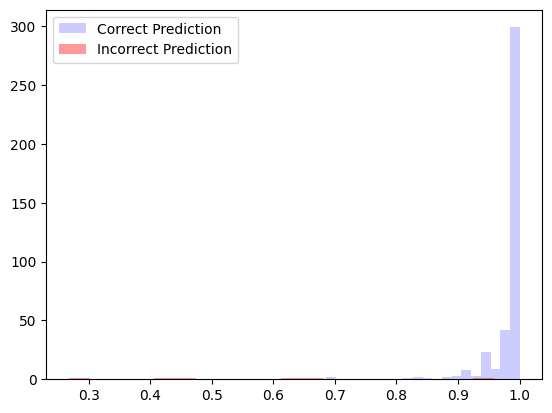

In [22]:
# Plot a value histogram for the known individual test
performace_train_5 = benchmark_train_5.performace.copy()
performace_train_5.to_csv("tables/01.2_Family_benchmark_performance.csv")

performace_train_5["correct_prediction"] = np.where(performace_train_5["ind"] == performace_train_5["prediction"], True, False)

mask = performace_train_5['correct_prediction'] == True
correct_df = performace_train_5[mask]
incorrect_df = performace_train_5[~mask]

# Plot the histograms

plt.hist(correct_df['similarity'], alpha=0.2, color='blue', bins = 20, label='Correct Prediction')
plt.hist(incorrect_df['similarity'], alpha=0.4, color='red', bins = 20, label='Incorrect Prediction')
plt.legend()
plt.savefig("report_figures/01.2_Family_benchmark_histogram_knownPhotos.png")
plt.show()

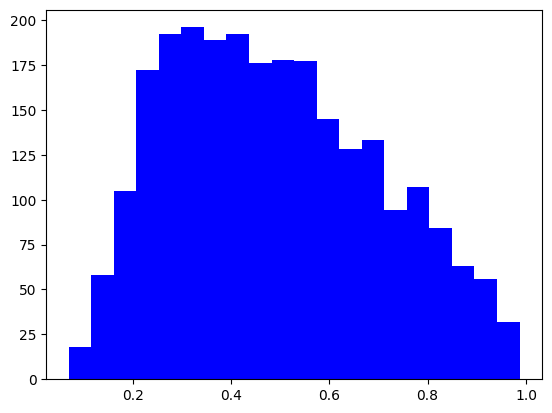

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [23]:
# Plot a value histogram for the unknown individual test
# Plot the histograms
performace_new_individuals_train_5 = benchmark_train_5.performace_new_individuals.copy()
performace_new_individuals_train_5.to_csv("tables/01.2_Family_benchmark_performance_new_inviduals.csv")

plt.hist(performace_new_individuals_train_5['similarity'], color='blue', bins = 20)
plt.savefig("report_figures/01.2_Family_benchmark_histogram_newPhotos.png")
plt.show()

metrics_table_new_individuals = output_metrics_table(performace_new_individuals_train_5, min_conf = min(performace_new_individuals_train_5["similarity"]), max_conf = 1, step = 0.05)

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


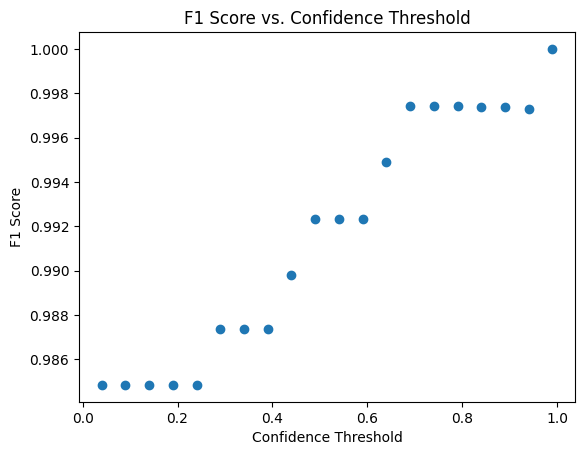

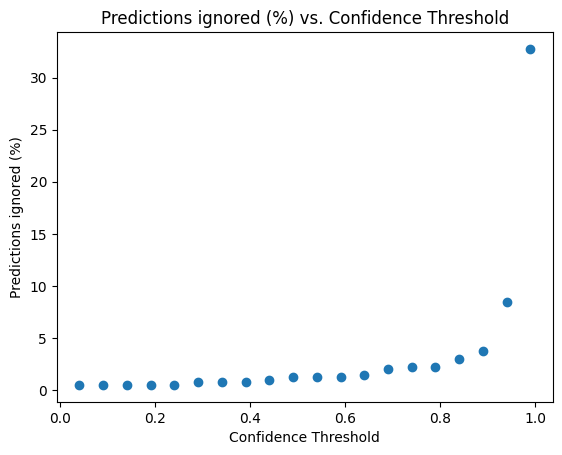

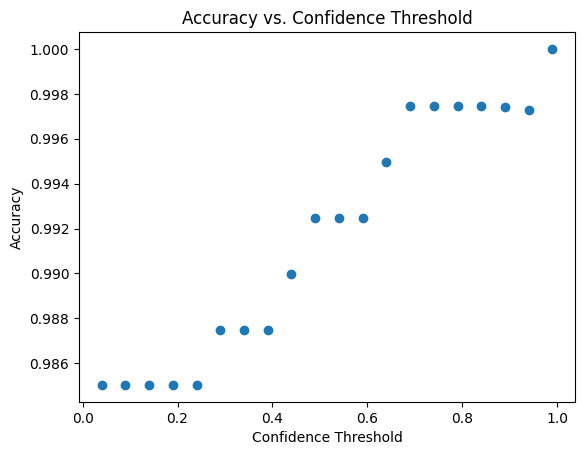

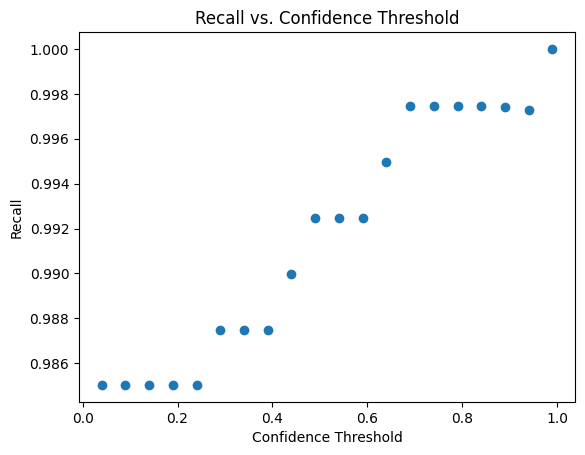

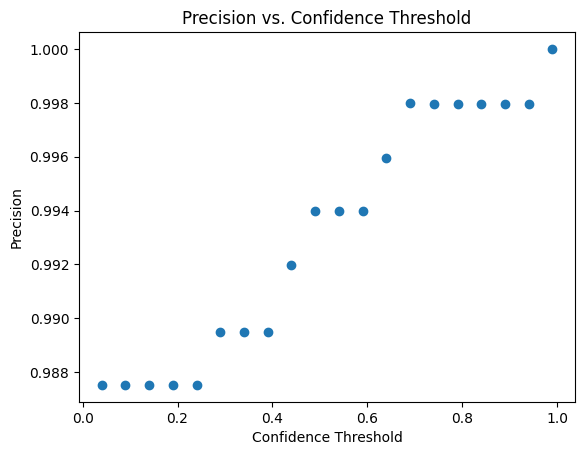

In [24]:
metrics_table = output_metrics_table(performace_train_5, min_conf = min(performace["similarity"]), max_conf = 1, step = 0.05)
metrics_table.to_csv("01.2_Family_benchmark_performance_metrics.csv")

# Filter out NaN values
metrics_table = metrics_table[~metrics_table["Accuracy"].isna()]


# Plot scatter plot of F1-score vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["F1 Score"])
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_F1vsConfidance.png")
plt.show()

plt.scatter(metrics_table["Confidence Threshold"], metrics_table["prediction_ignored"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Predictions ignored (%)")
plt.title("Predictions ignored (%) vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_PredictionsignoredVSConfidance.png")
plt.show()


# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Accuracy"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_AccuracyvsConfidance.png")
plt.show()

# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Recall"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_RecallvsConfidance.png")
plt.show()


# Plot scatter plot of Precision vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Precision"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_PrecisionvsConfidance.png")
plt.show()

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


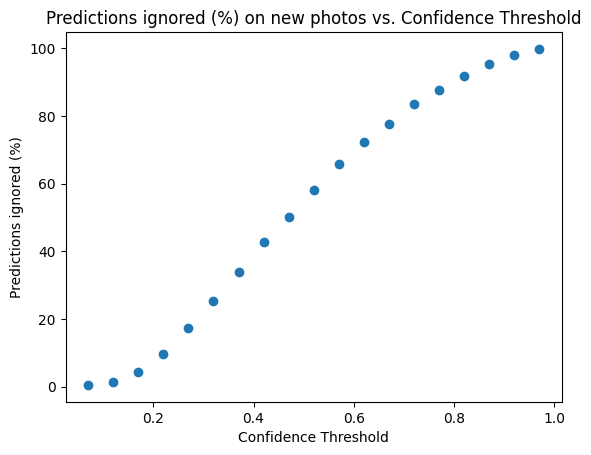

In [25]:
metrics_table_new_individuals = output_metrics_table(performace_new_individuals_train_5, min_conf = min(performace_new_individuals_train_5["similarity"]), max_conf = 1, step = 0.05)
metrics_table_new_individuals.to_csv("tables/01.2_Family_benchmark_performance_metrics_new_individuals.csv")
# Filter out NaN values
metrics_table_new_individuals = metrics_table_new_individuals[~metrics_table_new_individuals["Accuracy"].isna()]

plt.scatter(metrics_table_new_individuals["Confidence Threshold"], metrics_table_new_individuals["prediction_ignored"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Predictions ignored (%)")
plt.title("Predictions ignored (%) on new photos vs. Confidence Threshold")
plt.savefig("report_figures/01.2_Family_benchmark_scatterplot_PredictionsignoredNewIndividualsVSConfidance.png")
plt.show()

## Third Scenario:  Family of 4 Train using 20

In [15]:
benchmark_train_20 = Benchmark()
benchmark_train_20.family_benchmark(metadata_subset, n_interations = 25, 
                                   n_individuals = 4, n_photos_train = 5, n_photos_test_family = 4, 
                                   n_photos_test_group = 100)

Running iteration nº 0


/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/010951.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/038011.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/011443.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/comprefac

Running iteration nº 5


/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/025963.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/032033.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/014531.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/comprefac

Running iteration nº 10


/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/030050.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/012632.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/018635.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/comprefac

Running iteration nº 15


/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/164818.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/165104.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/163452.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/comprefac

Running iteration nº 20


/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/071744.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/069823.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/compreface/use_cases/add_example_of_subject.py:38: ResourceWarning: unclosed file <_io.BufferedReader name='../img_data/img_align_celeba/063246.jpg'>
  result: dict = self.add_example_of_subject.post(
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/comprefac

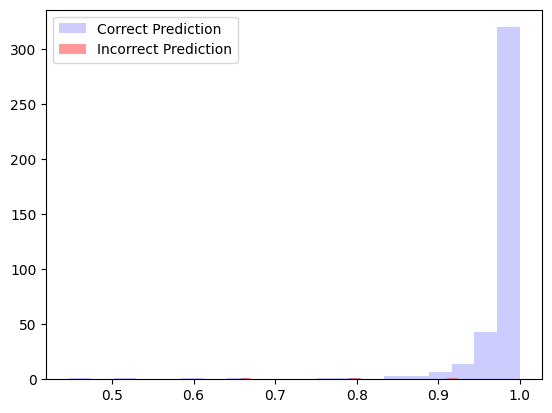

In [26]:
# Plot a value histogram for the known individual test
performace_train_20 = benchmark_train_20.performace.copy()
performace_train_20.to_csv("tables/01.3_Family_benchmark_performance.csv")

performace_train_20["correct_prediction"] = np.where(performace_train_20["ind"] == performace_train_20["prediction"], True, False)

mask = performace_train_20['correct_prediction'] == True
correct_df = performace_train_20[mask]
incorrect_df = performace_train_20[~mask]

# Plot the histograms

plt.hist(correct_df['similarity'], alpha=0.2, color='blue', bins = 20, label='Correct Prediction')
plt.hist(incorrect_df['similarity'], alpha=0.4, color='red', bins = 20, label='Incorrect Prediction')
plt.legend()
plt.savefig("report_figures/01.3_Family_benchmark_histogram_knownPhotos.png")
plt.show()


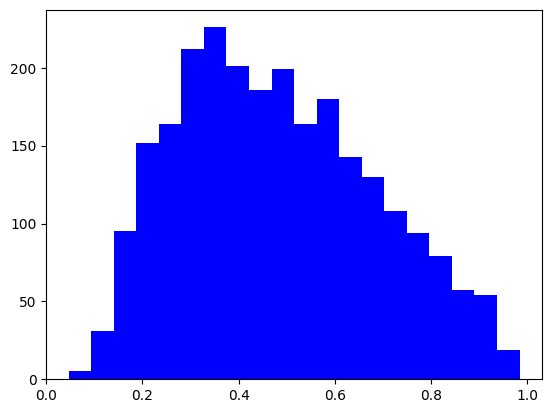

In [27]:
# Plot a value histogram for the unknown individual test
# Plot the histograms
performace_new_individuals_train_20 = benchmark_train_20.performace_new_individuals.copy()
performace_new_individuals_train_20.to_csv("tables/01.3_Family_benchmark_performance_new_inviduals.csv")

plt.hist(performace_new_individuals_train_20['similarity'], color='blue', bins = 20)
plt.savefig("report_figures/01.3_Family_benchmark_histogram_newPhotos.png")
plt.show()

/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


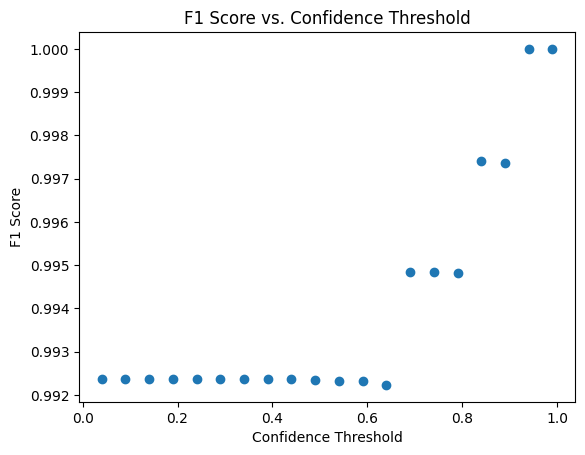

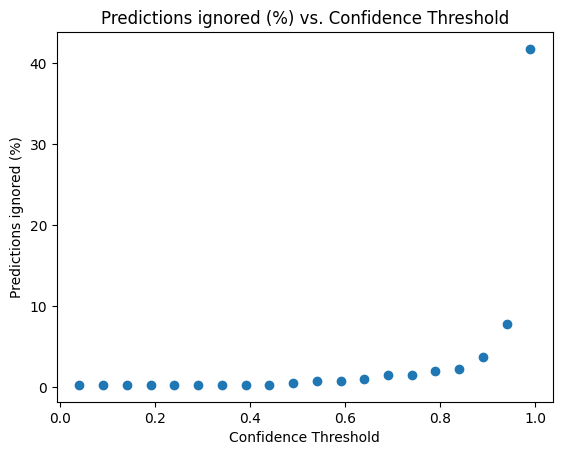

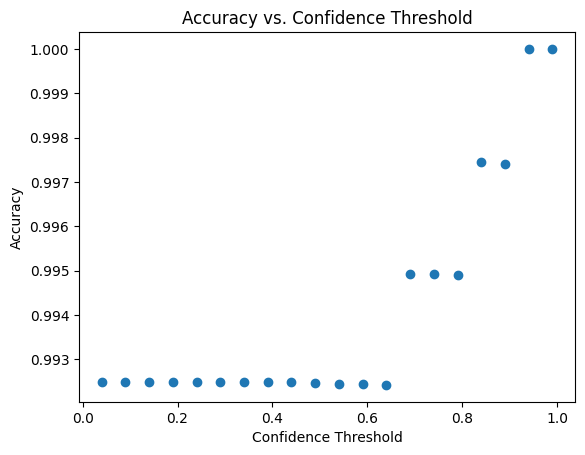

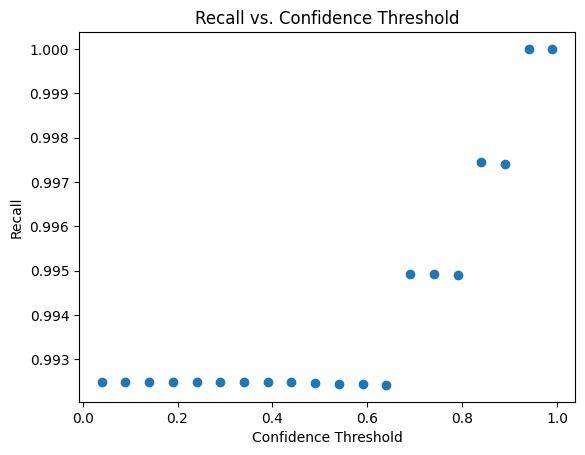

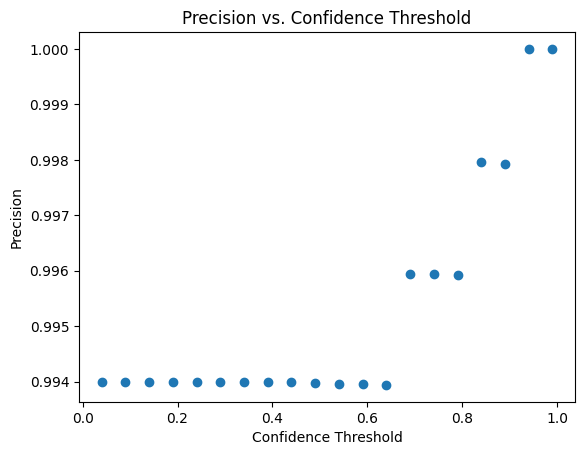

In [28]:
metrics_table = output_metrics_table(performace_train_20, min_conf = min(performace["similarity"]), max_conf = 1, step = 0.05)
metrics_table.to_csv("01.3_Family_benchmark_performance_metrics.csv")


# Filter out NaN values
metrics_table = metrics_table[~metrics_table["Accuracy"].isna()]

# Plot scatter plot of F1-score vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["F1 Score"])
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_F1vsConfidance.png")
plt.show()

plt.scatter(metrics_table["Confidence Threshold"], metrics_table["prediction_ignored"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Predictions ignored (%)")
plt.title("Predictions ignored (%) vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_PredictionsignoredVSConfidance.png")
plt.show()


# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Accuracy"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_AccuracyvsConfidance.png")
plt.show()

# Plot scatter plot of Accuracy vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Recall"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_RecallvsConfidance.png")
plt.show()


# Plot scatter plot of Precision vs. confidence threshold
plt.scatter(metrics_table["Confidence Threshold"], metrics_table["Precision"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_PrecisionvsConfidance.png")
plt.show()


/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rogerio/Documents/raceland-automacao/benchmark_deepstack/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


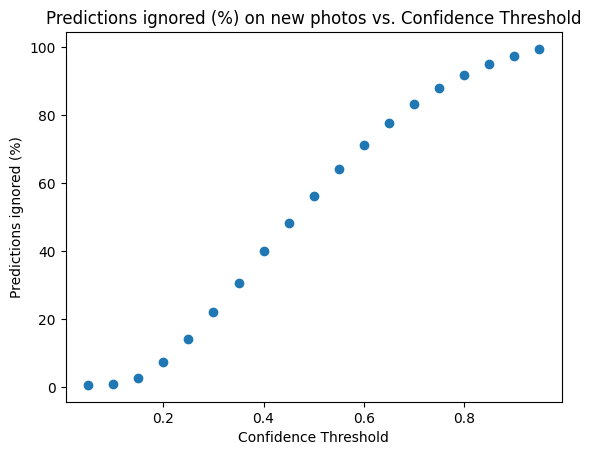

In [30]:
metrics_table_new_individuals = output_metrics_table(performace_new_individuals_train_20, min_conf = min(performace_new_individuals_train_20["similarity"]), max_conf = 1, step = 0.05)
metrics_table_new_individuals.to_csv("tables/01.3_Family_benchmark_performance_metrics_new_individuals.csv")
# Filter out NaN values
metrics_table_new_individuals = metrics_table_new_individuals[~metrics_table_new_individuals["Accuracy"].isna()]

plt.scatter(metrics_table_new_individuals["Confidence Threshold"], metrics_table_new_individuals["prediction_ignored"])
plt.xlabel("Confidence Threshold")
plt.ylabel("Predictions ignored (%)")
plt.title("Predictions ignored (%) on new photos vs. Confidence Threshold")
plt.savefig("report_figures/01.3_Family_benchmark_scatterplot_PredictionsignoredNewIndividualsVSConfidance.png")

plt.show()